This Notebook is for Image Recognition <a href = "https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/">Hackathon</a>  to classify vehicles are emergency or not
Put pictures



Pytorch has been used for the Process.

In [1]:
# Other modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from sklearn.metrics import accuracy_score,classification_report
import tqdm
from sklearn.metrics import accuracy_score,classification_report
import tqdm
import os
import time
from mpl_toolkits.axes_grid1 import ImageGrid
import random

In [2]:
# Torch modules
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from collections import OrderedDict
from torchvision import transforms, utils , models
from torch.optim.lr_scheduler import StepLR
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Directories
image_dir = '../input/vehicle-images/images'

In [4]:
# Reading the csv file

df_train = pd.read_csv('../input/vehicle-images/train.csv')

df_test = pd.read_csv('../input/test-data/submission.csv')
class_names = ['not_emergency','emergency']

In [5]:
# Checking the number of training examples and test examples
num_train,num_test = df_train.shape[0],df_test.shape[0]

print(f'The number of training examples are {num_train} and testing are {num_test}')

The number of training examples are 1646 and testing are 706


The training data is less in number so splitting the data into train and validation set is skipped and accuracy of the test data will be checked regularly to gauge the model.

Data Augmentation is used to expand the training dataset.

In [6]:
# Declaration of few varaibles
num_epochs = 50
batch_size = 128
learning_rate = 0.0001

Vehicle Class created. This takes the id and will return image and class from that id by referring train_df.

In [7]:
class VehicleDataset(Dataset):
    def __init__(self,data,root_dir,transform,train=True):
        self.root_dir = root_dir
        self.transform = transform['train'] if train==True else transform['validation']
        self.X = data['image_names']
        self.y = data['emergency_or_not']
        
    
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self,idx):
        name= self.X.loc[idx]
        img_name = os.path.join(self.root_dir,name)
        image = Image.open(img_name)
        
        
        
        image = self.transform(image)
        
        label = self.y.loc[idx]
        return image,label
 



In [8]:
def imshow(inp, title):
    """Imshow for Tensor."""
    plt.subplots(figsize=(35,35))
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


Class Random Noise created which will add noise to the images choosen randomly.

In [9]:
import random

class RandomNoise(object):
    def __init__(self, p=1):
         self.probability = p
    def __call__(self, tensor):
        if random.random() <= self.probability:
            return tensor + torch.randn(tensor.size()) * .25 + 0.5
            
        return tensor

All the transformations to be done.

In [10]:
# Transforms
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


data_transforms = {
    'train': transforms.Compose([
        
            transforms.Resize(256),
            transforms.ColorJitter(),
            transforms.RandomAffine(degrees=(-45,+45),scale=(0.9,1.2),translate=(0.2,0.2),shear = (0.2,0.2)),
            transforms.RandomVerticalFlip(p=0.1),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3, fill=0),
            torchvision.transforms.RandomGrayscale(p=0.15),
            
            transforms.ToTensor(),
            transforms.RandomErasing(0.05),
            transforms.Normalize(mean, std),
            RandomNoise(p=0.4)
            
        
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


In [11]:
# counts = df_train.emergency_or_not.value_counts().values
# weights = 1/counts
# df_train['weights'] = df_train.emergency_or_not.apply(lambda x:weights[x])

# sampler = WeightedRandomSampler(list(df_train['weights']),num_samples=batch_size)

In [12]:
train = VehicleDataset(df_train,image_dir,transform=data_transforms,train=True)

dataloader = {'train':DataLoader(train,shuffle=True,batch_size=batch_size)}

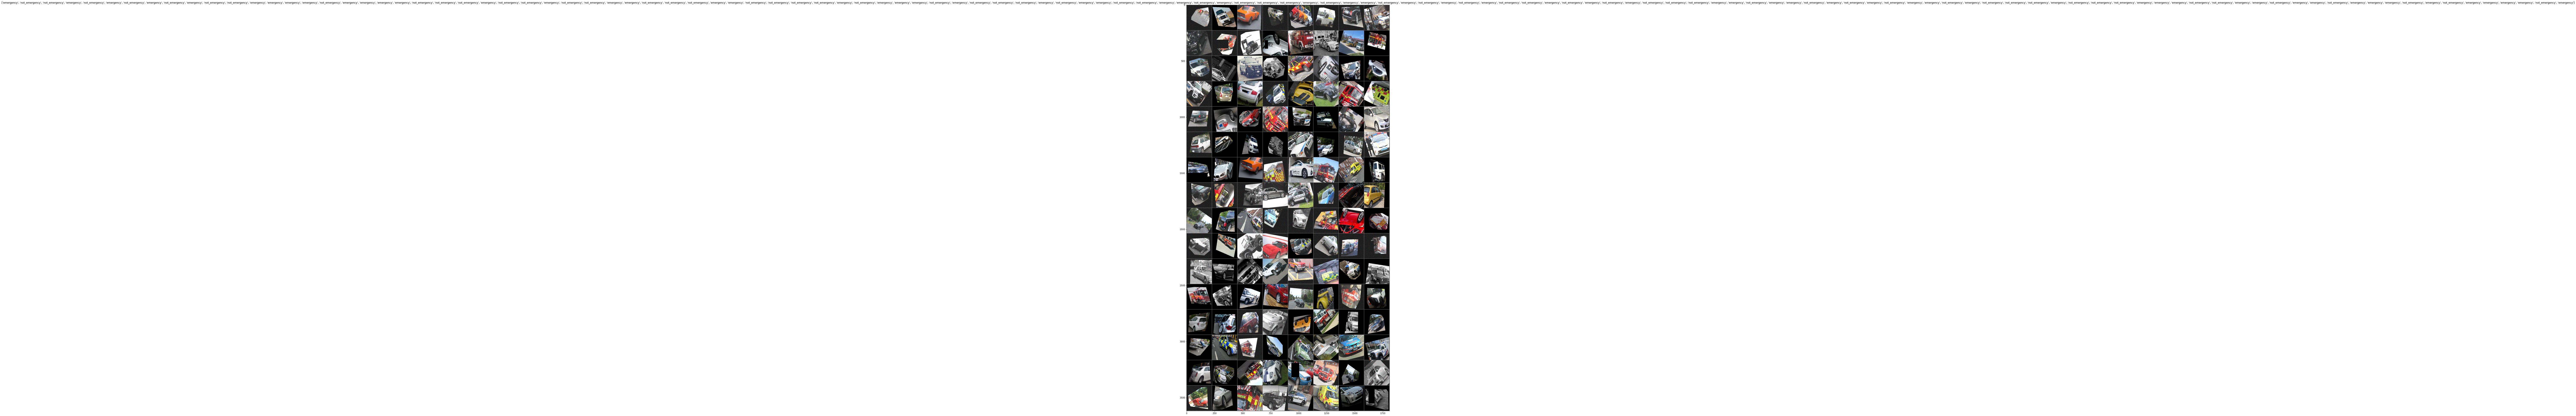

In [13]:
class_names = ['not_emergency','emergency']
images,classes=next(iter(dataloader['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in classes])

In [14]:
#TRAINING THE NETWORK
def train(model, device, train_loader, optimizer):
    model.train()
    y_true = []
    y_pred = []
    losses = []
    for i in train_loader:
      
    #LOADING THE DATA IN A BATCH
        data, target = i
        
#         check

        
        target = target.type(torch.float)
    #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        data, target = data.to(device), target.to(device)
       
        #FORWARD PASS
        output = model(data.float())
        
        loss = criterion(output, target.unsqueeze(1)) 
                
#         #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         # PREDICTIONS
        output = torch.sigmoid(output)
#         out_values = 1/(1+torch.exp(output.detach()))
        pred = torch.round(output.detach())
        target = torch.round(target.detach())  
        
        y_pred.extend(pred.tolist())
        y_true.extend(target.tolist())
        losses.append(loss.detach())
        
        
        
#     Getting accuracy and loss for the eopch
    accuracy = round((accuracy_score(y_true,y_pred)).item(),4)
    avg_loss = round((sum(losses)/len(losses)).item(),4)
    print(f"Epoch Accuracy on training set is {accuracy} and loss is  {avg_loss}")
    
#     Checking confusion matrix
    print(classification_report(y_true,y_pred,target_names=class_names))

    return accuracy,avg_loss

In [15]:
def start_traininng(model):
    training_accuracy = []
    training_loss = []
    testing_accuracy = []
    testing_loss = []
    for epoch in range(num_epochs):
                # Decay Learning Rate

            t0 = time.time()
            # Print Learning Rate
            print('Epoch:', epoch)
            print('Learning rate ',scheduler.get_last_lr())
            acc_train,loss_train = train(model,device,dataloader['train'],optimizer)
    #         acc_test,loss_test = test(model,device,dataloader['validation'])

            training_accuracy.append(acc_train)
            training_loss.append(loss_train)
    #         testing_accuracy.append(acc_test)
    #         testing_loss.append(loss_test)

    #         Learning rate schedular
            scheduler.step()
        
#             time taken
            t1 = time.time()
            print(t1-t0)

    return training_accuracy,training_loss

In [16]:
# This function predict the outputs from the trained model
def predict_result(model):
    model.eval()
    predictions= []
    for file in tqdm.tqdm_notebook(df_test.image_names):
        file_path = image_dir + '/' + file
        img = Image.open(file_path)
        
        img = data_transforms['val'](img)
        data = img.to(device)
        data=data.unsqueeze(0)
        output = model(data)
        output = torch.sigmoid(output)
        pred = int(torch.round(output).item())
        predictions.append(pred)
    return predictions

In [17]:
# Finetuning resent 18
model = models.resnet50(pretrained=True)
# Creating model and setting loss and optimizer.
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
fc = nn.Sequential(OrderedDict([
    
    ('fc1', nn.Linear(num_ftrs,1)),
    
]))
model.fc = fc


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [18]:
# # Freezing layers
# child_counter = 0
# for child in model.children():
#     if child_counter < 5:
#         print("child ",child_counter," was frozen")
#         for param in child.parameters():
#             param.requires_grad = False
#         child_counter += 1
#     else:
#         print("child ",child_counter," was not frozen")
#         child_counter += 1

In [ ]:
# Creating model, criterion, optimizer and schedular 
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate , weight_decay=3e-2)
# gamma = decaying factor
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# train resnet 18
training_accuracy,training_loss = start_traininng(model)

Epoch: 0
Learning rate  [0.0001]


In [ ]:
# Plot accuracy
plt.plot(training_accuracy)

    

In [ ]:
# Plot accuracy
plt.plot(training_loss)

In [ ]:
df_test = pd.read_csv('../input/test-data/submission.csv')
df_test.drop('emergency_or_not',axis=1,inplace=True)

In [ ]:
# prediction
predictions=predict_result(model)
df_test['emergency_or_not'] = predictions
df_test.to_csv('submit.csv',index=False)

The best accuracy for the Test Data was 0.976076555023923.